In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy.linalg as la
import pandas as pd
from scipy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D
import random
from pipeline import generate_basic_exploration
import jellyfish

In [21]:
df = pd.read_csv('allegations.csv')

In [22]:
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition'],
      dtype='object')

In [23]:
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


In [24]:
df['unique_mos_id']

0        10004
1        10007
2        10007
3        10007
4        10009
         ...  
33353     9992
33354     9992
33355     9992
33356     9992
33357     9992
Name: unique_mos_id, Length: 33358, dtype: int64

In [25]:
# Construct variable based on time to close case

df['month_received'] = [str(x) for x in df['month_received']]
df['year_received'] = [str(x) for x in df['year_received']]
df['month_closed'] = [str(x) for x in df['month_closed']]
df['year_closed'] = [str(x) for x in df['year_closed']]

df['received_date'] = pd.to_datetime(df['month_received'] + '-' + df['year_received'])
df['closed_date'] = pd.to_datetime(df['month_closed'] + '-' + df['year_closed'])
df['closure_time'] = (df['closed_date'] - df['received_date']).dt.days

In [26]:
# Create continuous rank variable

In [27]:
rank_dict = {'POM': 1, 'POF': 1, 'PO': 1, 'PSA':1,
             'SGT': 2, 'SSA': 2, 'SDS': 2, 'DET': 3,
             'DT3': 3, 'DTS': 3, 'DT2': 4, 'DT1': 5,
             'LT': 6, 'LSA': 6, 'LCD': 7, 'SRG': 7,
             'CPT': 8, 'SCS': 8, 'DCS': 8, 'DI': 8,
             'INS': 9, 'DC': 9, 'AC': 9,
             'COD': 10, 'CCA': 10, 'CCT': 10, 'CD': 10,
             'CMS': 10, 'COH': 10, 'COP': 10, 'COS':10,
             'COT': 10, 'CPB': 10, 'CCC': 10, 'COI': 10}
# Rank --> continuous values using dict
df['rank_abbrev_incident'] = [rank_dict[x] for x in df['rank_abbrev_incident']]
df['rank_abbrev_now'] = [rank_dict[x] for x in df['rank_abbrev_now']]

# Potential additional outcome variable for demotion?
df['demotion'] = df['rank_abbrev_now'] < df['rank_abbrev_incident']
df['promotion'] = df['rank_abbrev_now'] > df['rank_abbrev_incident']

In [28]:
np.mean(df['closure_time']), np.mean(df['demotion']), np.mean(df['promotion'])

# Average time to close a complaint roughly 1 year
# Less than 1% of officers were of lower rank after the incident
# 47% of officers were higher rank after the incident

(296.2687211463517, 0.009622879069488579, 0.47376941063612926)

In [29]:
# Ethnicity & gender
df['mos_ethnicity'].unique(), df['complainant_ethnicity'].unique(), df['mos_gender'].unique()

(array(['Hispanic', 'White', 'Black', 'Asian', 'American Indian'],
       dtype=object),
 array(['Black', nan, 'White', 'Asian', 'Refused', 'Hispanic', 'Unknown',
        'Other Race', 'American Indian'], dtype=object),
 array(['M', 'F'], dtype=object))

In [30]:
# Constructing a variable based on whether the officer had the same
# ethnicity as the complainant
df['complainant_ethnicity'] = df['complainant_ethnicity'].fillna('Unknown')
df['same_ethnicity'] = df['mos_ethnicity']== df['complainant_ethnicity']
df['same_ethnicity'] = [int(x) for x in df['same_ethnicity']]

In [31]:
# Other race variables
for race_eth in df['mos_ethnicity'].unique():
    mos_race_eth = 'mos_' + race_eth.lower().replace(' ', '_')
    df[mos_race_eth] = df['mos_ethnicity'] == race_eth


In [32]:
for race_eth in df['complainant_ethnicity'].unique():
    c_race_eth = 'c_' + race_eth.lower().replace(' ', '_')
    df[c_race_eth] = df['complainant_ethnicity'] == race_eth

In [33]:
df['complainant_gender'] = df['complainant_gender'].fillna('Not described')
for gender in df['complainant_gender'].unique():
    c_gender = 'c_' + gender.lower().replace(' ', '_')
    df[c_gender] = df['complainant_gender'] == gender
df['complainant_gender'].unique()

array(['Female', 'Male', 'Not described', 'Transman (FTM)',
       'Transwoman (MTF)', 'Gender non-conforming'], dtype=object)

In [34]:
# Constructing gender variables including same officer/complainant gender,
# 0/1 variable for officer gender,
# Male dummy, Non-conforming dummy, Trans dummies for complainants

df['same_gender'] = df['mos_gender']==df['complainant_gender']
gender_dict = {'F': 1, 'M': 0}
df['mos_gender'] = [gender_dict[x] for x in df['mos_gender']]

In [35]:
# Converting complaint types into categories: How do we want to go about this?

#IDEAS: Construct subcategories within existing top-level categories?
# For now: dummies for major types

#Could create continuous variables for sexual misconduct,
# use of force, etc
df['allegation'] = df['allegation'].fillna('Other')
df['fado_type'].unique(), df['allegation'].unique()


(array(['Abuse of Authority', 'Discourtesy', 'Offensive Language', 'Force'],
       dtype=object),
 array(['Failure to provide RTKA card', 'Action', 'Race', 'Question',
        'Physical force', 'Refusal to process civilian complaint',
        'Sexual orientation', 'Word', 'Refusal to provide shield number',
        'Retaliatory summons', 'Refusal to provide name/shield number',
        'Search (of person)', 'Pepper spray', 'Handcuffs too tight',
        'Frisk', 'Vehicle stop', 'Vehicle search', 'Strip-searched',
        'Threat of arrest', 'Threat of force (verbal or physical)', 'Stop',
        'Refusal to obtain medical treatment',
        'Hit against inanimate object', 'Frisk and/or search', 'Other',
        'Question and/or stop', 'Premises entered and/or searched',
        'Gun Drawn', 'Nonlethal restraining device', 'Retaliatory arrest',
        'Seizure of property', 'Chokehold', 'Gender',
        'Nightstick as club (incl asp & baton)', 'Refusal to provide name',
        'Gun

In [36]:
# Creating dummies as well as a fado_nums variable which increases with severity of
# allegation

fado_dict = {'Force': 4, 'Abuse of Authority': 3, 'Discourtesy': 2, 'Offensive Language': 1}
df['fado_nums'] = [fado_dict[x] for x in df['fado_type']]
for f_type in df['fado_type'].unique():
    fado_type = f_type.lower().replace(' ', '_')
    df[fado_type] = df['fado_type'] == f_type

In [37]:
jellyfish.jaro_winkler('Refusal to provide name', 'Flashlight as club')

0.5140901771336553

In [38]:
sim_dict = {}
matched_dict = {}
matched_vals = []
for alleg in df['allegation'].unique():
    if alleg not in matched_vals:
        sim_dict[alleg] = [alleg]
        for other_alleg in df['allegation'].unique():
            if other_alleg not in sim_dict and other_alleg not in matched_vals:
                if jellyfish.jaro_winkler(alleg, other_alleg) > 0.89:
                    sim_dict[alleg].append(other_alleg)
                    matched_vals.append(other_alleg)
for key in sim_dict:
    if len(sim_dict[key]) > 1:
        matched_dict[key] = sim_dict[key]

In [39]:
merged_strings = []
for match in matched_dict:
    m = match.lower()
    for other_match in matched_dict[match]:
        other_match = str.split(other_match.lower())
        for word in other_match:
            if word not in m:
                m = m + '_merge_' + word
    merged_strings.append(m)
matched_dict, merged_strings

({'Refusal to provide shield number': ['Refusal to provide shield number',
   'Refusal to provide name/shield number',
   'Refusal to provide name'],
  'Vehicle stop': ['Vehicle stop', 'Vehicle'],
  'Vehicle search': ['Vehicle search', 'Vehicle Searched'],
  'Threat of arrest': ['Threat of arrest',
   'Threat of force',
   'Threat of Arrest'],
  'Other': ['Other', 'Other Asian'],
  'Gun Pointed': ['Gun Pointed', 'Gun pointed'],
  'Property damaged': ['Property damaged', 'Property Damaged'],
  'Refusal to show search warrant': ['Refusal to show search warrant',
   'Refusal to show arrest warrant'],
  'Sex Miscon (Sexual Harassment, Verbal)': ['Sex Miscon (Sexual Harassment, Verbal)',
   'Sex Miscon (Sexual Harassment, Gesture)'],
  'Threat of summons': ['Threat of summons', 'Threat of Summons'],
  'Flashlight as club': ['Flashlight as club', 'Flashlight As Club'],
  'Gun as club': ['Gun as club', 'Gun As Club'],
  'Radio As Club': ['Radio As Club', 'Radio as club'],
  'Gun fired': ['Gun

In [40]:
drop_cols = []
for key in matched_dict:
    for val in matched_dict[key]:
        drop_cols.append(val)

In [41]:
drop_cols

['Refusal to provide shield number',
 'Refusal to provide name/shield number',
 'Refusal to provide name',
 'Vehicle stop',
 'Vehicle',
 'Vehicle search',
 'Vehicle Searched',
 'Threat of arrest',
 'Threat of force',
 'Threat of Arrest',
 'Other',
 'Other Asian',
 'Gun Pointed',
 'Gun pointed',
 'Property damaged',
 'Property Damaged',
 'Refusal to show search warrant',
 'Refusal to show arrest warrant',
 'Sex Miscon (Sexual Harassment, Verbal)',
 'Sex Miscon (Sexual Harassment, Gesture)',
 'Threat of summons',
 'Threat of Summons',
 'Flashlight as club',
 'Flashlight As Club',
 'Gun as club',
 'Gun As Club',
 'Radio As Club',
 'Radio as club',
 'Gun fired',
 'Gun Fired']

In [42]:
for allegation in df['allegation'].unique():
    df[allegation] = df['allegation'] == allegation

In [43]:
df['refusal to provide shield number_merge_name/shield'] = (df['Refusal to provide shield number'] +
                                                            df['Refusal to provide name/shield number'] +
                                                            df['Refusal to provide name'])
df['vehicle stop'] = df['Vehicle stop'] + df['Vehicle']
df['vehicle search_merge_searched'] = df['Vehicle search'] + df['Vehicle Searched']
df['threat of arrest_merge_force']  = df['Threat of arrest'] + df['Threat of force'] + df['Threat of Arrest']
df['gun pointed'] = df['Gun Pointed'] + df['Gun pointed']
df['property damaged'] = df['Property damaged'] + df['Property Damaged']
df['refusal to show search warrant_merge_arrest'] = df['Refusal to show search warrant'] + df['Refusal to show arrest warrant']
df['sex miscon (sexual harassment, verbal)_merge_gesture)'] = (df['Sex Miscon (Sexual Harassment, Verbal)'] +
                                                               df['Sex Miscon (Sexual Harassment, Gesture)'])
df['threat of summons'] = df['Threat of summons'] + df['Threat of Summons']
df['flashlight as club'] = df['Flashlight as club'] + df['Flashlight As Club']
df['gun as club'] = df['Gun as club'] + df['Gun As Club']
df['radio as club'] = df['Radio As Club'] + df['Radio as club']
df['gun fired'] = df['Gun fired'] + df['Gun Fired']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [44]:
df = df.drop(columns=drop_cols)

In [45]:
complainant_cols = [x for x in merged_strings if x != 'other_merge_asian']

In [46]:
remaining_c_cols = []
for allegation in df['allegation'].unique():
    if allegation not in drop_cols and allegation != 'Other':
        remaining_c_cols.append(allegation)

In [47]:
remaining_c_cols

['Failure to provide RTKA card',
 'Action',
 'Race',
 'Question',
 'Physical force',
 'Refusal to process civilian complaint',
 'Sexual orientation',
 'Word',
 'Retaliatory summons',
 'Search (of person)',
 'Pepper spray',
 'Handcuffs too tight',
 'Frisk',
 'Strip-searched',
 'Threat of force (verbal or physical)',
 'Stop',
 'Refusal to obtain medical treatment',
 'Hit against inanimate object',
 'Frisk and/or search',
 'Question and/or stop',
 'Premises entered and/or searched',
 'Gun Drawn',
 'Nonlethal restraining device',
 'Retaliatory arrest',
 'Seizure of property',
 'Chokehold',
 'Gender',
 'Nightstick as club (incl asp & baton)',
 'Threat to notify ACS',
 'Other blunt instrument as a club',
 'Interference with recording',
 'Threat to damage/seize property',
 'Gesture',
 'Forcible Removal to Hospital',
 'Entry of Premises',
 'Ethnicity',
 'Other - Force',
 'Search of Premises',
 'Threat re: removal to hospital',
 'Photography/Videography',
 'Demeanor/tone',
 'Curse',
 'Dragged/P

In [48]:
# Setting this aside to try string similarity approach

# group_cols = []
# id_cols = ['Refusal to provide name', 'Refusal to provide shield number', 
#            'Refusal to provide name/shield number', 'Failure to provide RTKA card']
# club_cols = ['Flashlight as club',   'Flashlight As Club',  
#              'Nightstick as club (incl asp & baton)',   
#              'Other blunt instrument as a club', 'Gun as club',  
#              'Radio As Club', 'Nightstick/Billy/Club', 'Radio as club']
# vehicle_cols = ['Vehicle search',  'Vehicle Searched']
# gesture_cols = ['Gesture',  'Rude Gesture',  'Profane Gesture']
# gun_cols = ['Gun Pointed', 'Gun pointed/gun drawn', 'Gun pointed', 'Gun Drawn']
# person_search_cols = ['Search (of person)',  'Frisk and/or search', 
#                       'Person Searched']
# premises_search_cols = ['Premises entered and/or searched',  'Search of Premises', 
#                         'Premise Searched', 'Entry of Premises']

In [49]:
# How to approach contact & outcome variables?

# Could do dummies based on subtypes?
df['contact_reason'] = df['contact_reason'].fillna('Other')
df['outcome_description'] = df['outcome_description'].fillna('Unknown')
df['contact_reason'].unique(), df['outcome_description'].unique()

(array(['Report-domestic dispute', 'Moving violation',
        'PD suspected C/V of violation/crime - street', 'Report-dispute',
        'C/V telephoned PCT', 'Other', 'Regulatory inspection',
        'Other violation of VTL', 'Parking violation',
        'Execution of search warrant',
        'PD suspected C/V of violation/crime - bldg',
        'Execution of arrest/bench warrant',
        'PD suspected C/V of violation/crime - auto',
        'Report-possession/sale of narcotics', 'Report-noise/disturbance',
        'C/V intervened on behalf of/observed encounter w/3rd party',
        'Traffic accident', 'Aided case', 'EDP aided case',
        'C/V at PCT to file complaint of crime', 'Report of other crime',
        'PD auto checkpoint', 'Demonstration/protest',
        'Arrest/Complainant', 'C/V requested investigation of crime',
        'Assist ACS or other agency', 'C/V at PCT to obtain information',
        'CV already in custody', 'Report-gun possession/shots fired',
        'Tra

In [50]:
new_officer_cols = []
for contact_reason in df['contact_reason'].unique():
    df[contact_reason] = df['contact_reason'] == contact_reason
    new_officer_cols.append(contact_reason)
for outcome in df['outcome_description'].unique():
    df[outcome] = df['outcome_description'] == outcome
    new_officer_cols.append(outcome)
    
# With these new cols, we get Singular Matrix errors

In [51]:
# Preliminary manual go for reason. 
# Could redo this with Jaro-Winkler/ other measure of similarity?

df['dispute'] = (df['Report-domestic dispute'] + df['Report-dispute'] + df['Dispute'])
df['vehicle'] = (df['Moving violation'] + df['Other violation of VTL'] +
                 df['PD suspected C/V of violation/crime - auto'] +
                 df['Traffic Incidents/Accident/Prk Violation'] +
                 df['Parking violation'] + df['Traffic accident'] +
                 df['Vehicle Stop and Check'])
df['suspected_violation'] = (df['PD suspected C/V of violation/crime - subway'] +
                             df['PD suspected C/V of violation/crime - street'] +
                             df['PD suspected C/V of violation/crime - bldg'])
df['phone'] = (df['C/V telephoned PCT'] + df['PD telephones CV'] +
               df['Telephone Call to Precinct/Command'])
df['warrant'] = (df['Execution of search warrant'] +
                 df['Execution of arrest/bench warrant'] +
                 df['Report-possession/sale of narcotics'])
df['aided_case'] = (df['Aided case'] + df['EDP aided case'] +
                    df['EDP Aided Cases'] + df['Aided Cases'])
df['checkpoint'] = (df['PD auto checkpoint'] + df['Transit checkpoint'])
df['demonstrations_protests'] = (df['Demonstration/protest'] +
                                 df['Demonstrations'])
df['report'] = (df['Report of other crime'] + df['Report of Crime Past/Present'] +
                df['C/V requested investigation of crime'])
df['disturbance'] = (df['Report-noise/disturbance'] +
                     df['Report of Disturbance/Noise Complaint'])
df['precinct_complaint_info'] = (df['Complainant at Pct. to make a Cmpl/info'] +
                                df['C/V at PCT to obtain information'])

In [52]:
# Preliminary manual go for outcomes

df['vehicle_violation'] = (df['Moving violation summons issued'] + 
                           df['Other VTL violation summons issued'] + 
                           df['Traffic Summons Claimed or Issued'])
df['arrest_resist'] = (df['Arrest - resisting arrest'] + 
                       df['Resisting Arrest/Arrested'])
df['arrest_obstruct'] = (df['Arrest - OGA'] + df['Obstruct-Govt-Admin/Arrested'])
df['other_summons'] = (df['Other Summons Claimed or Issued'] +
                       df['Summons - other violation/crime'])

In [53]:
constructed_cols = ['dispute', 'vehicle', 'suspected_violation',
                    'phone', 'warrant', 'aided_case', 'checkpoint',
                    'demonstrations_protests', 'report',
                    'disturbance', 'precinct_complaint_info',
                    'vehicle_violation', 'arrest_resist',
                    'arrest_obstruct', 'other_summons']

In [54]:
remaining_cols = ['Arrest/Complainant',
                  'C/V intervened on behalf of/observed encounter w/3rd party',
                  'C/V at PCT to file complaint of crime', 
                  'Regulatory inspection',
                  'Assist ACS or other agency',
                  'CV already in custody',
                  'Report-gun possession/shots fired',
                  'Stop/Question/Frisk',
                  'C/V requested info from officer',
                  'Patrol Encounter',
                  'Arrest/Not Complainant',
                  'Summons/Complainant',
                  'Complainant Witnessing Incident',
                  'C/V at PCT to retrieve property',
                  'Parade/special event',
                  'Victim Subject of Sex Crime',
                  'No contact',
                  'Arrest - other violation/crime',
                  'No arrest made or summons issued',
                  'Assault/Arrested',
                  'Arrest - harrassment (against a PO)',
                  'Arrest on Other Charge',
                  'Harrassment/Arrested/Summons',
                  'Arrest - disorderly conduct',
                  'Arrest - assault (against a PO)',
                  'Summons - disorderly conduct',
                  'Summons - harrassment (against a PO)',
                  'Parking summons issued',
                  'Disorderly-Conduct/Arr/Summons',
                  'Juvenile Report']

In [55]:
# How to key in the board disposition

# Simple approach: Unsubstantiated = -1, Exonerated = 0, all categories of Substantiated = 1
# More complex approach: break down Substantiated into continuous values?

# Could be interesting to add a dummy for how often complaints are substantiated
# when officer is unidentified
df['board_disposition'].unique()

array(['Substantiated (Command Lvl Instructions)',
       'Substantiated (Charges)', 'Substantiated (Command Discipline A)',
       'Substantiated (Formalized Training)', 'Unsubstantiated',
       'Exonerated', 'Substantiated (Command Discipline B)',
       'Substantiated (Instructions)',
       'Substantiated (Command Discipline)',
       'Substantiated (No Recommendations)',
       'Substantiated (MOS Unidentified)'], dtype=object)

In [56]:
outcomes_dict = {'Substantiated (Command Lvl Instructions)': 1,
                 'Substantiated (Charges)': 1, 
                 'Substantiated (Command Discipline A)': 1,
                 'Substantiated (Formalized Training)': 1,
                 'Substantiated (Command Discipline B)': 1,
                 'Substantiated (Instructions)': 1,
                 'Substantiated (Command Discipline)': 1,
                 'Substantiated (No Recommendations)': 1,
                 'Substantiated (MOS Unidentified)': 1,
                 'Exonerated': 0,
                 'Unsubstantiated': -1}
df['outcome'] = [outcomes_dict[x] for x in df['board_disposition']]

In [57]:
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed',
       ...
       'checkpoint', 'demonstrations_protests', 'report', 'disturbance',
       'precinct_complaint_info', 'vehicle_violation', 'arrest_resist',
       'arrest_obstruct', 'other_summons', 'outcome'],
      dtype='object', length=249)

In [58]:
# Alternative - replace all ages below 0 with NA then fill all NAs with median?
df.loc[df['complainant_age_incident']<=0,'complainant_age_incident'] = np.nan
df['complainant_age_incident'] = df['complainant_age_incident'].fillna(df['complainant_age_incident'].median())

In [59]:
df['complainant_age_incident'] = df['complainant_age_incident'].fillna(0)
df['complainant_age_incident'] = [int(x) for x in df['complainant_age_incident']]

In [60]:
df['complainant_age_incident'].unique()
# We see some outliers with negative values and 0 values for NAs.
# Here we replace these values with 0
df['complainant_age_incident'] = [0 if x < 0 else x for x in df['complainant_age_incident']]

In [61]:
df['complainant_age_incident'].unique()

array([ 38,  26,  45,  16,  31,  34,  60,  39,  30,  35,  42,  46,  23,
        29,  28,  22,  33,  17,  15,  50,  27,  24,  43,  37,  25,  19,
        47,  20,  49,  36,  67,  53,  44,  58,  40,  55,  18,  21,  41,
        32,  52,  51,  65,  57,  48,  14,  13,  56,  64,  77,  63,  10,
        54,  68,  62,  73,  11,  59,  74,  61,  80,  90,  70,  75,  12,
        72,   8,  71,  69,  76,  81,  66,  87,   9, 101,   1,  78,   2,
        88,  83,  79,  84,   3,   7,   6,  86])

In [62]:
sub_df = df[['rank_abbrev_incident', 'mos_ethnicity', 'mos_gender', 'mos_age_incident', 
             'complainant_ethnicity', 'complainant_age_incident', 'complainant_gender',
             'fado_nums', 'precinct', 'board_disposition', 'closure_time', 'outcome']]

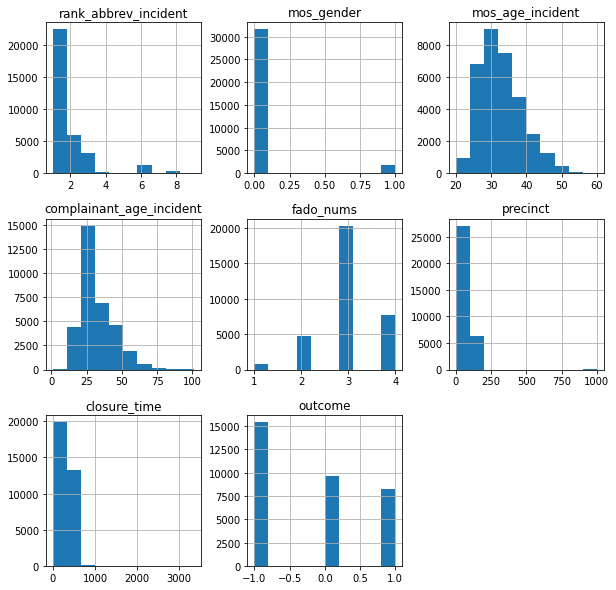

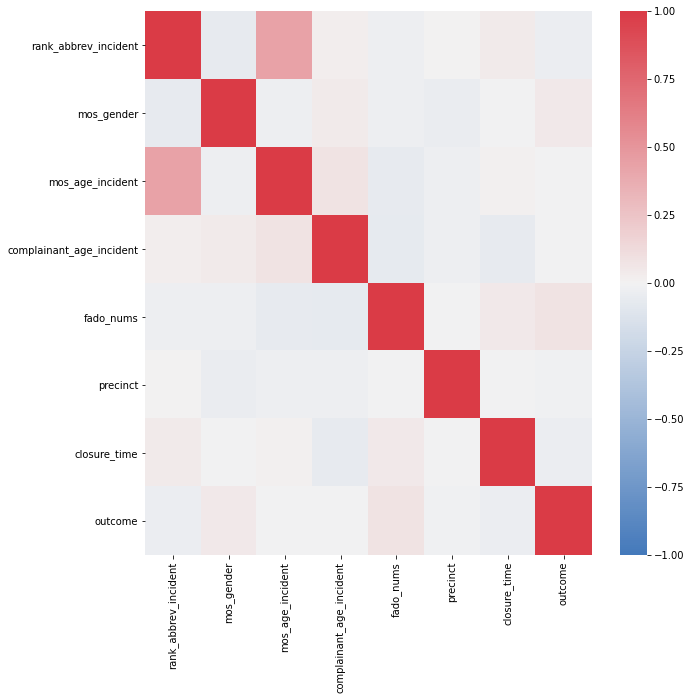

In [63]:
generate_basic_exploration(sub_df)

In [64]:
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition', 'received_date', 'closed_date', 'closure_time',
       'demotion', 'promotion', 'same_ethnicity', 'mos_hispanic', 'mos_white',
       'mos_black', 'mos_asian', 'mos_american_indian', 'c_black', 'c_unknown',
       'c_white', 'c_asian', 'c_refused', 'c_hispanic', 'c_other_race',
       'c_american_indian', 'c_female', 'c_male', 'c_not_described',
       'c_transman_(ftm)', 'c_transwoman_(mtf)', 'c_gender_non-conforming',
       'same_gender', 'fado_nums', 'abuse_of

In [65]:
remaining_c_cols = [x for x in remaining_c_cols if x not in ['Sexist Remark', 
                                                             'Questioned immigraiton status',
                                                             'Failure to provide RTKA card']]

In [66]:
remaining_c_cols

['Action',
 'Race',
 'Question',
 'Physical force',
 'Refusal to process civilian complaint',
 'Sexual orientation',
 'Word',
 'Retaliatory summons',
 'Search (of person)',
 'Pepper spray',
 'Handcuffs too tight',
 'Frisk',
 'Strip-searched',
 'Threat of force (verbal or physical)',
 'Stop',
 'Refusal to obtain medical treatment',
 'Hit against inanimate object',
 'Frisk and/or search',
 'Question and/or stop',
 'Premises entered and/or searched',
 'Gun Drawn',
 'Nonlethal restraining device',
 'Retaliatory arrest',
 'Seizure of property',
 'Chokehold',
 'Gender',
 'Nightstick as club (incl asp & baton)',
 'Threat to notify ACS',
 'Other blunt instrument as a club',
 'Interference with recording',
 'Threat to damage/seize property',
 'Gesture',
 'Forcible Removal to Hospital',
 'Entry of Premises',
 'Ethnicity',
 'Other - Force',
 'Search of Premises',
 'Threat re: removal to hospital',
 'Photography/Videography',
 'Demeanor/tone',
 'Curse',
 'Dragged/Pulled',
 'Push/Shove',
 'Detentio

In [68]:
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition', 'received_date', 'closed_date', 'closure_time',
       'demotion', 'promotion', 'same_ethnicity', 'mos_hispanic', 'mos_white',
       'mos_black', 'mos_asian', 'mos_american_indian', 'c_black', 'c_unknown',
       'c_white', 'c_asian', 'c_refused', 'c_hispanic', 'c_other_race',
       'c_american_indian', 'c_female', 'c_male', 'c_not_described',
       'c_transman_(ftm)', 'c_transwoman_(mtf)', 'c_gender_non-conforming',
       'same_gender', 'fado_nums', 'abuse_of

In [70]:
def train_test_split(X, y, train_size, random_seed=0):
    random.seed(random_seed)
    all_inds = list(range(len(y)))
    train_inds = random.sample(range(len(y)), train_size)
    test_inds = [x for x in all_inds if x not in train_inds]
    train_X = X.iloc[train_inds]
    train_Y = y[train_inds]
    test_X = X.iloc[test_inds]
    test_Y = y[test_inds]
    return train_X, train_Y, test_X, test_Y

In [71]:
y = df['outcome']
y = y.astype(float)
failed_cols = []
new_cols = []
for clmn in remaining_c_cols:

    officer_vars = (['rank_abbrev_incident', 'mos_gender', 'mos_age_incident', 
                    'same_ethnicity',  'closure_time','demotion','promotion','rank_abbrev_now'] 
                    + constructed_cols 
                    + remaining_cols)
#                 + remaining_cols_2)
# complainant_vars = ['complainant_age_incident', 'fado_nums']
#Attempting to replace fado_nums with dummies
    complainant_vars = (['complainant_age_incident', 
                         'abuse_of_authority', 'discourtesy',
                         'offensive_language', 'force',
#                          'force', 'power', 'rude', 'words',
                         'c_black', 'same_ethnicity',
                           'c_unknown', 'c_white', 'c_asian', 'c_hispanic',
                           'c_american_indian',
                        'c_female', 'c_male','c_transman_(ftm)', 'c_transwoman_(mtf)',
                        'c_gender_non-conforming'] 
                        + complainant_cols + [clmn] + new_cols)
    X = df[officer_vars + complainant_vars]
    for col in X:
        X[col] = X[col].astype(float)
    train_X, train_y, test_X, test_y = train_test_split(X, y, round(len(y)*0.8))
    try:
        w_hat = la.inv(train_X.T@train_X)@train_X.T@train_y
        new_cols.append(clmn)
        print('Column addition succeeded at {}'.format(clmn))
    except:
        failed_cols.append(clmn)
        print('Column addition failed at {}'.format(clmn))
        
        

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Column addition succeeded at Action
Column addition succeeded at Race
Column addition succeeded at Question
Column addition succeeded at Physical force
Column addition succeeded at Refusal to process civilian complaint
Column addition succeeded at Sexual orientation
Column addition succeeded at Word
Column addition succeeded at Retaliatory summons
Column addition succeeded at Search (of person)
Column addition succeeded at Pepper spray
Column addition succeeded at Handcuffs too tight
Column addition succeeded at Frisk
Column addition succeeded at Strip-searched
Column addition succeeded at Threat of force (verbal or physical)
Column addition succeeded at Stop
Column addition succeeded at Refusal to obtain medical treatment
Column addition succeeded at Hit against inanimate object
Column addition succeeded at Frisk and/or search
Column addition succeeded at Question and/or stop
Column addition succeeded at Premises entered and/or searched
Column addition succeeded at Gun Drawn
Column ad

In [72]:
mos_eth_vars = ['mos_hispanic', 'mos_black', 'mos_asian', 'mos_american_indian']

In [78]:
# Test run
officer_vars = (['rank_abbrev_incident', 'mos_gender', 'mos_age_incident', 
                'same_ethnicity',  'closure_time','demotion','promotion','rank_abbrev_now'] 
                + constructed_cols 
                + remaining_cols
                + mos_eth_vars)
# complainant_vars = ['complainant_age_incident', 'fado_nums']
#Attempting to replace fado_nums with dummies
complainant_vars = (['complainant_age_incident', 
                        'abuse_of_authority', 'discourtesy',
                         'offensive_language', 'force',
#                      'force', 'power', 'rude', 'words',
                     'c_black', 
                       'c_unknown', 'c_white', 'c_asian', 'c_hispanic',
                       'c_american_indian',
                    'c_female', 'c_male','c_transman_(ftm)', 'c_transwoman_(mtf)',
                    'c_gender_non-conforming'] 
                    + complainant_cols
                    + new_cols)
X = df[officer_vars + complainant_vars]
y = df['outcome']

In [79]:
y = y.astype(float)
for col in X:
    X[col] = X[col].astype(float)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
X.shape

(33358, 168)

In [245]:
train_X, train_y, test_X, test_y = train_test_split(X, y, round(len(y)*0.8))

In [85]:
train_X.shape

(26686, 60)

In [246]:
U, S, VT = la.svd(np.array(X), full_matrices=False)

In [247]:
S

array([6.13248197e+04, 4.24503488e+03, 1.53739105e+03, 2.15519566e+02,
       1.27068501e+02, 1.14594781e+02, 1.01484966e+02, 9.93689585e+01,
       9.87417144e+01, 9.52716251e+01, 8.62774655e+01, 8.25159025e+01,
       7.22149023e+01, 6.83734553e+01, 5.99750887e+01, 5.90374057e+01,
       4.66027873e+01, 4.56756549e+01, 4.52869791e+01, 4.44726727e+01,
       4.25213023e+01, 4.18326035e+01, 4.16354750e+01, 4.09176375e+01,
       3.97753141e+01, 3.89604220e+01, 3.86353857e+01, 3.72819505e+01,
       3.67565122e+01, 3.52738647e+01, 3.42280294e+01, 3.31722262e+01,
       3.27061790e+01, 3.22032774e+01, 3.06954021e+01, 3.05307527e+01,
       2.97498447e+01, 2.79985978e+01, 2.72233652e+01, 2.64004515e+01,
       2.55744272e+01, 2.44642159e+01, 2.34870170e+01, 2.30905130e+01,
       2.26395291e+01, 2.24894631e+01, 2.17627731e+01, 2.06272994e+01,
       2.03767678e+01, 1.92262233e+01, 1.83452614e+01, 1.80381019e+01,
       1.72755849e+01, 1.72173983e+01, 1.65993152e+01, 1.63490833e+01,
      

In [127]:
U@np.diag(S)@VT

array([[ 1.00000000e+00,  7.37353120e-14,  3.20000000e+01, ...,
         3.47823967e-17, -1.62769840e-17, -6.48886750e-17],
       [ 1.00000000e+00,  6.86598641e-14,  2.40000000e+01, ...,
         6.12897574e-16, -1.92845459e-16, -1.40465703e-16],
       [ 1.00000000e+00,  6.67832686e-14,  2.40000000e+01, ...,
        -6.11058195e-17, -7.97488588e-17, -6.38600783e-17],
       ...,
       [ 1.00000000e+00, -8.50400270e-14,  3.60000000e+01, ...,
        -6.75493446e-17,  3.37721972e-18, -1.17074395e-16],
       [ 1.00000000e+00, -8.50400270e-14,  3.60000000e+01, ...,
        -6.75493446e-17,  3.37721972e-18, -1.17074395e-16],
       [ 1.00000000e+00, -8.50569128e-14,  3.60000000e+01, ...,
        -6.70215935e-17,  3.83941643e-18, -1.17081143e-16]])

In [43]:
np.array(X)

array([[ 1.,  0., 32., ...,  0.,  0.,  0.],
       [ 1.,  0., 24., ...,  0.,  0.,  0.],
       [ 1.,  0., 24., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0., 36., ...,  0.,  0.,  0.],
       [ 1.,  0., 36., ...,  0.,  0.,  0.],
       [ 1.,  0., 36., ...,  0.,  0.,  0.]])

In [248]:
w_hat = la.inv(train_X.T@train_X)@train_X.T@train_y
w_hat
#Female officers has a positive coefficient on substantiated claims

0     -0.026170
1      0.153854
2      0.001813
3     -0.024083
4     -0.000249
5      0.004262
6     -0.099516
7     -0.074405
8     -0.014233
9     -0.155314
10     0.111485
11     0.084848
12    -0.001266
13     0.023737
14     0.042581
15     0.097879
16     0.125443
17     0.130066
18     0.059602
19     0.104305
20    -0.234904
21     0.046028
22    -0.002961
23    -0.359003
24     0.000422
25    -0.011089
26    -0.162459
27     0.081301
28     0.108785
29    -0.172434
30    -0.326746
31    -0.257762
32    -0.829985
33    -0.047734
34    -0.061172
35    -0.741399
36    -0.275140
37     0.027171
38     0.161501
39    -0.176658
40    -0.084768
41    -0.116677
42     0.727626
43     0.120355
44     0.053399
45     0.049610
46    -0.283291
47     0.244284
48    -0.022123
49     0.172881
50    -0.019443
51    -0.013816
52     0.071912
53    -0.178848
54     0.000112
55    -0.391821
56     0.287237
57     0.279752
58    -0.461595
59    -0.011254
60     0.059647
61     0.034549
62     0

In [249]:
train_preds = np.array(train_X)@np.array(w_hat)
train_preds = [-1 if x < -0.5 else x for x in train_preds]
train_preds = [1 if x > 0.5 else x for x in train_preds]
train_preds = [0 if x not in (-1, 1) else x for x in train_preds]

# predictions = np.array(test_X)@np.array(w_hat)
print(test_X.shape, w_hat.shape)
predictions = np.array(test_X)@np.array(w_hat)
predictions = [np.round(x) for x in predictions]

(6672, 165) (165,)


In [250]:
sum(predictions)

-985.0

In [251]:
train_error = ((np.array(train_preds)-train_y))
train_error = [abs(x) for x in train_error]
sum(train_error) / len(train_error)

0.6140298283744285

In [82]:
new_df = X.copy()
new_df['officer_id'] = df['unique_mos_id']
new_df['outcome'] = y

In [83]:
len(new_df.columns)

170

In [84]:
new_df.to_csv('allegations_cleaned2.csv')